<a href="https://colab.research.google.com/github/LudovicoLentini/AML-Crowd-Counting/blob/main/ShangaiTech_CSRNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%time
import os
if not os.path.exists('CSRNet-pytorch/'):
    !pip install -U scipy torch_snippets torch_summary
    # !git clone https://github.com/sizhky/CSRNet-pytorch.git
    from google.colab import files
    files.upload() # upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    print('downloading data...')
    !kaggle datasets download -d tthien/shanghaitech-with-people-density-map/
    print('unzipping data...')
    !unzip -qq shanghaitech-with-people-density-map.zip

%cd CSRNet-pytorch
!ln -s ../shanghaitech_with_people_density_map
from torch_snippets import *
import h5py
from scipy import io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'CSRNet-pytorch'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Unpacking objects: 100% (92/92), done.


Saving kaggle.json to kaggle.json
kaggle.json


downloading data...

shanghaitech-with-people-density-map.zip: Skipping, found more recently modified local copy (use --force to force download)


unzipping data...

[shanghaitech-with-people-density-map.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of shanghaitech-with-people-density-map.zip or
        shanghaitech-with-people-density-map.zip.zip, and cannot find shanghaitech-with-people-density-map.zip.ZIP, period.
/content/CSRNet-pytorch
CPU times: user 278 ms, sys: 115 ms, total: 392 ms
Wall time: 20.5 s


In [ ]:
!ls

sample_data			      shanghaitech-with-people-density-map.zip
shanghaitech_with_people_density_map


In [ ]:
!ls

dataset.py		    part_B_test.json
image.py		    part_B_train.json
make_dataset.ipynb	    part_B_train_with_val.json
make_model.ipynb	    part_B_val.json
model.py		    README.md
part_A_test.json	    shanghaitech_with_people_density_map
part_A_train.json	    train.py
part_A_train_with_val.json  utils.py
part_A_val.json		    val.ipynb


In [ ]:
#explore a bit the pictures involved
import json

with open('part_A_train.json') as f:
  part_A_train = json.load(f)

part_A_train[0]

'/home/leeyh/Downloads/Shanghai/part_A_final/train_data/images/IMG_73.jpg'

In [ ]:
#define paths of folders:

part_A = Glob('shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/');

image_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/'
heatmap_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth-h5/'
gt_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth/'


In [ ]:
stems(Glob(image_folder))[0]

'IMG_182'

## Use GPU


In [ ]:
# Select GPU device for the training if available
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

Current device: cuda - Type: Tesla T4

In [ ]:
tfm = T.Compose([
    T.ToTensor()
])

class Crowds(Dataset):
    def __init__(self, stems):
        self.stems = stems

    def __len__(self):
        return len(self.stems)

    def __getitem__(self, ix):
        _stem = self.stems[ix]
        image_path = f'{image_folder}/{_stem}.jpg'
        heatmap_path = f'{heatmap_folder}/{_stem}.h5'
        gt_path = f'{gt_folder}/GT_{_stem}.mat'

        pts = io.loadmat(gt_path)
        pts = len(pts['image_info'][0,0][0,0][0])

        image = read(image_path, 1)
        with h5py.File(heatmap_path, 'r') as hf:
            gt = hf['density'][:]
        gt = resize(gt, 1/8)*64   ##
        return image.copy(), gt.copy(), pts

    def collate_fn(self, batch):
        ims, gts, pts = list(zip(*batch))
        ims = torch.cat([tfm(im)[None] for im in ims]).to(device)
        gts = torch.cat([tfm(gt)[None] for gt in gts]).to(device)
        return ims, gts, torch.tensor(pts).to(device)

    def choose(self):
        return self[randint(len(self))]


from sklearn.model_selection import train_test_split
trn_stems, val_stems = train_test_split(stems(Glob(image_folder)), random_state=10)

trn_ds = Crowds(trn_stems)
val_ds = Crowds(val_stems)

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)


In [ ]:
print(len(trn_dl))
print(len(val_dl))

225

75

In [ ]:
import torch.nn as nn
import torch
from torchvision import models
from utils import save_net,load_net

#Dilated CNN function
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [ ]:
#network architecture - CSRNet

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)

            self._initialize_weights()
            items = list(self.frontend.state_dict().items())
            _items = list(mod.state_dict().items())

            for i in range(len(self.frontend.state_dict().items())):
                items[i][1].data[:] = _items[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    loss.backward()
    optimizer.step()
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

## Running the model

In [ ]:
import matplotlib.pyplot as plt

225

0

torch.Size([1, 3, 418, 628])

torch.Size([1, 1, 52, 78])

torch.Size([1])

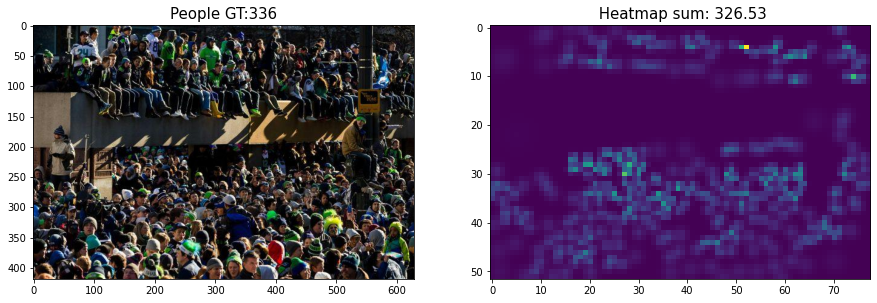

In [ ]:
#explore the data elements:
print(len(trn_dl))
for bx, data in enumerate(trn_dl):
  print(bx)
  # print(data)
  ims, gts, pts = data

  print(ims.shape)
  print(gts.shape)
  print(pts.shape)

  # print('gts:\n', gts[0][0]) image shape

  fig, axis = plt.subplots(1,2,figsize = (15,8))
  # fig.suptitle('Shangaitech Data',size=20)

  axis[0].imshow(ims[0].permute(1, 2, 0).cpu())
  axis[0].set_title(f'People GT:{pts.item()}', size=15)

  sum_heat = np.round(sum(sum(gts[0][0])).item(),2)
  axis[1].imshow(gts[0][0].cpu())
  axis[1].set_title(f' Heatmap sum: {sum_heat}',size=15)

  # axis[2].hist(gts[0][0].flatten().cpu(),bins=100)
  # axis[2].set_title(f' Hist')

  break



## Model

In [ ]:
model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
n_epochs = 20 #usually 20

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, pts_loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_pts_loss=pts_loss, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, pts_loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_pts_loss=pts_loss, end='\r')

    log.report_avgs(ex+1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH: 1.000  val_pts_loss: 315.436  trn_pts_loss: 428.241  trn_loss: 0.054  val_loss: 0.038  (85.23s - 1619.30s remaining)
EPOCH: 2.000  val_pts_loss: 253.844  trn_pts_loss: 327.710  trn_loss: 0.046  val_loss: 0.032  (171.43s - 1542.88s remaining)
EPOCH: 3.000  val_pts_loss: 146.358  trn_pts_loss: 253.346  trn_loss: 0.040  val_loss: 0.030  (258.02s - 1462.11s remaining)
EPOCH: 4.000  val_pts_loss: 146.506  trn_pts_loss: 173.572  trn_loss: 0.038  val_loss: 0.028  (344.19s - 1376.78s remaining)
EPOCH: 5.000  val_pts_loss: 141.902  trn_pts_loss: 151.484  trn_loss: 0.036  val_loss: 0.028  (430.40s - 1291.20s remaining)
EPOCH: 6.000  val_pts_loss: 149.184  trn_pts_loss: 154.944  trn_loss: 0.035  val_loss: 0.027  (516.86s - 1206.00s remaining)
EPOCH: 7.000  val_pts_loss: 133.982  trn_pts_loss: 143.287  trn_loss: 0.034  val_loss: 0.027  (603.29s - 1120.39s remaining)
EPOCH: 8.000  val_pts_loss: 138.427  trn_pts_loss: 142.894  trn_loss: 0.035  val_loss: 0.026  (689.53s - 1034.30s remaining)
E

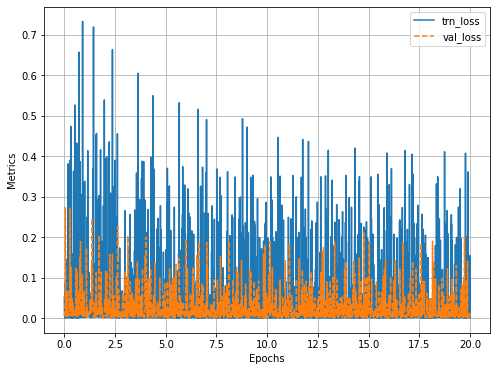

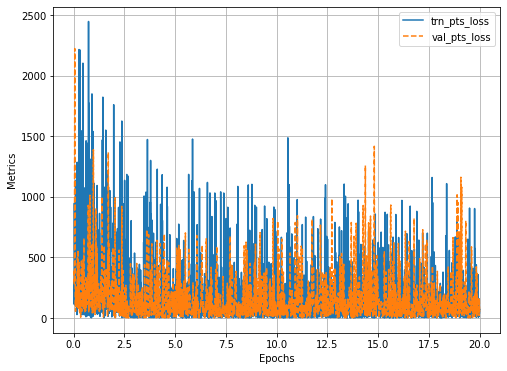

In [ ]:
# log.report_avgs(1)

log.plot(['trn_loss','val_loss'])
log.plot(['trn_pts_loss','val_pts_loss'])

## save result averages to plot later

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AML/Project/

/content/drive/MyDrive/AML/Project


In [ ]:
trn_loss = []
val_loss = []
trn_pts_loss = []
val_pts_loss = []
for i in range(21):
  trn_loss.append(log.report_avgs(i+1)['epoch_trn_loss'])
  val_loss.append(log.report_avgs(i+1)['epoch_val_loss'])
  trn_pts_loss.append(log.report_avgs(i+1)['epoch_trn_pts_loss'])
  val_pts_loss.append(log.report_avgs(i+1)['epoch_val_pts_loss'])

df = pd.DataFrame(list(zip(trn_loss,val_loss,trn_pts_loss,val_pts_loss)) )
df
# df.to_csv('CSRNet_res1.csv')

EPOCH: 1.000  val_pts_loss: 315.436  trn_pts_loss: 428.241  trn_loss: 0.054  val_loss: 0.038  (11534.21s - 219150.00s remaining)
EPOCH: 1.000  val_pts_loss: 315.436  trn_pts_loss: 428.241  trn_loss: 0.054  val_loss: 0.038  (11534.22s - 219150.13s remaining)
EPOCH: 1.000  val_pts_loss: 315.436  trn_pts_loss: 428.241  trn_loss: 0.054  val_loss: 0.038  (11534.22s - 219150.20s remaining)
EPOCH: 1.000  val_pts_loss: 315.436  trn_pts_loss: 428.241  trn_loss: 0.054  val_loss: 0.038  (11534.22s - 219150.24s remaining)
EPOCH: 2.000  val_pts_loss: 253.844  trn_pts_loss: 327.710  trn_loss: 0.046  val_loss: 0.032  (11534.23s - 103808.03s remaining)
EPOCH: 2.000  val_pts_loss: 253.844  trn_pts_loss: 327.710  trn_loss: 0.046  val_loss: 0.032  (11534.23s - 103808.05s remaining)
EPOCH: 2.000  val_pts_loss: 253.844  trn_pts_loss: 327.710  trn_loss: 0.046  val_loss: 0.032  (11534.23s - 103808.06s remaining)
EPOCH: 2.000  val_pts_loss: 253.844  trn_pts_loss: 327.710  trn_loss: 0.046  val_loss: 0.032  (11

## Test result on random image

Image shape:
torch.Size([3, 265, 701])

f1 shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_28.mat

gt
{
    '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 18 20:05:31 2016',
    '__version__': '1.0',
    '__globals__': []
}

tensor[1, 1, 33, 87] n=2871 x∈[0.002, 0.253] μ=0.065 σ=0.049 grad ConvolutionBackward0 cuda:0

Predicted Count :  187

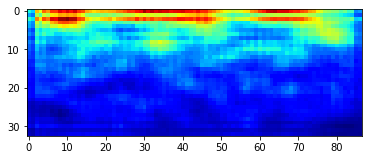

In [ ]:
from matplotlib import cm as c
from torchvision import datasets, transforms
from PIL import Image
import scipy
import sklearn
from sklearn.feature_extraction import image
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


transform=transforms.Compose([
 transforms.ToTensor(),transforms.Normalize(\
 mean=[0.485, 0.456, 0.406],\
 std=[0.229, 0.224, 0.225]),\
 ])
test_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/'
imgs = Glob(f'{test_folder}/images')
# f = choose(imgs) #
f = imgs[0]
# print(f)
img = transform(Image.open(f).convert('RGB')).to(device)
print('Image shape:',img.shape)

## gt elements:
gts = Glob(f'{test_folder}/ground-truth')
f1 = gts[0]
print('f1',f1)
# gt = transform(Image.open(f1).convert('RGB')).to(device)
##
gt = loadmat(f1,variable_names='IMAGES',appendmat=True) #.get('IMAGES')
print('gt',gt)
# plt.imshow(gt[:,:,0])

output = model(img[None])
print(output)
print("Predicted Count : ", int(output.detach().cpu().sum().numpy()))

temp = np.asarray(output.detach().cpu()\
 .reshape(output.detach().cpu()\
 .shape[2],output.detach()\
 .cpu().shape[3]))

# print(temp)
plt.imshow(temp,cmap = c.jet)
plt.show()

Text(0.5, 1.0, ' Heatmap: 736.43')

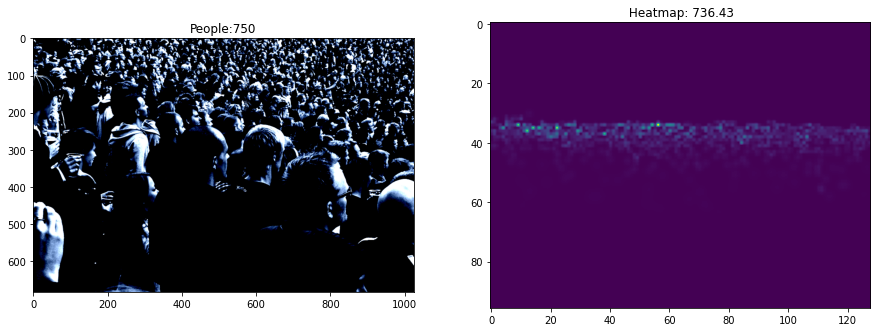

In [ ]:
fig, axis = plt.subplots(1,2,figsize = (15,8))
axis[0].imshow(im.permute(1, 2, 0).cpu())
axis[0].set_title(f'People:{pts.item()}')

sum_heat = np.round(sum(sum(gts[0][0])).item(),2)
axis[1].imshow(gts[0][0].cpu())
axis[1].set_title(f' Heatmap: {sum_heat}')